# Phase 4 Project Submission¶
- Student name: Lucas Wilkerson
- Student pace: Flex/part time
- Scheduled project review date/time:
- Instructor name: Morgan Jones

# Pneumonia Detection and Classification

## Project Overview

For this project, the aim is to build a model for image classification that can classify whether a patient has pneumonia when provided a chest x-ray image. 

## Business Problem and Stakeholder

A healthcare physician group is looking to improve their patient outcomes, specifically patients who are being diagnosed with pneumonia. Pneumonia is a significant health concern among patients, especially geriatric and pediatric patients. For effective treatment and the best possible outcomes, early detection and diagnosis is crucial. Current methods for diagnosing pneumonia can be time-consuming and can be prone to error. Through the development and use of method such as image classification and deep learning, we may be able to improve this process which can lead to an increase in early accurate identification and as a result improve patient outcomes.


## Data Understanding

The dataset used for this project contains chest X-ray images from pediatric patients with or without pneumonia who are ages one to five who. The dataset is already separated and organized into three groups:

- Train: data used for training the model
- Test: data used for testing and evaluating the model's performance 
- Validation: data used during the training process to help tune the model



## Data Preparation/ Preprocessing

To start the preparation and preprocessing phase, the necessary packages will be imported for this project. Next a directory path will be made to each of the three dataset groups: training data, test data, validation data. The images will be loaded and also rescaled. 


In [8]:
# May add this in

# Data augmentation will also be utilized to help decrease the likely-hood of the model overfitting 
# and increase the chances of the model being able to generalize on unseen data.

In [1]:
#importing necessary packages

from tensorflow.keras.utils import array_to_img, img_to_array, load_img

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import Adam
from keras.utils import array_to_img, img_to_array, load_img
from keras.regularizers import l1 , l2 
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This prevents kernel shut down due to xgboost conflict
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # This line prevents tf's comments about the optimizing your machine

In [2]:
# Directory path
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Get all the data in the directory chest_xray/train (5216 images) and reshape them
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=5216, class_mode='binary')

# Get all the data in the directory chest_xray/test (624 images) , and reshape them
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=624, class_mode='binary')


# Get all the data in the directory chest_xray/val (16 images), and reshape them
val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=16, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [3]:
# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Get the counts for each class in the training set
train_class_counts = np.bincount(train_labels.astype(int))
train_class_counts_dict = dict(zip(range(len(train_class_counts)), train_class_counts))
print("Training Set Class Counts:", train_class_counts_dict)

# Get the counts for each class in the test set
test_class_counts = np.bincount(test_labels.astype(int))
test_class_counts_dict = dict(zip(range(len(test_class_counts)), test_class_counts))
print("Test Set Class Counts:", test_class_counts_dict)

# Get the counts for each class in the validation set
val_class_counts = np.bincount(val_labels.astype(int))
val_class_counts_dict = dict(zip(range(len(val_class_counts)), val_class_counts))
print("Validation Set Class Counts:", val_class_counts_dict)

In [6]:
# Previewing shape of each dataset

print("Image Dataset Shape")
print("Train:", train_images.shape)
print("Test:", test_images.shape)
print("Validation:", val_images.shape)

print("Label Dataset Shape")
print("Train:", train_labels.shape)
print("Test:", test_labels.shape)
print("Validation:", val_labels.shape)



Image Dataset Shape
Train: (5216, 256, 256, 3)
Test: (624, 256, 256, 3)
Validation: (16, 256, 256, 3)
Label Dataset Shape
Train: (5216,)
Test: (624,)
Validation: (16,)


Looking at the shapes of the datasets, we can derive the total number of images per group, along with the size of each image. 
- Training set: 5216 images 
- Test set: 624 images 
- Validation set: 16 images
- Image size: 256 x 256 x 3 

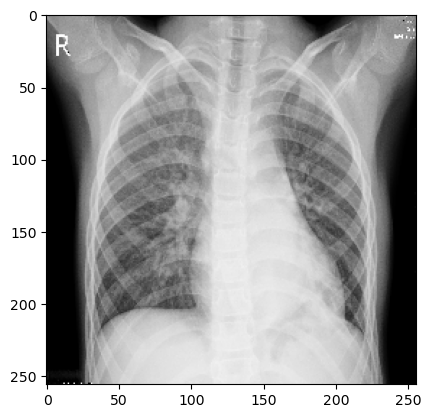

In [7]:
# Previewing sample images from training set
example_img = train_images[10]
plt.imshow(example_img)

In [11]:
# Reshaping image datasets for modeling 
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 196608)
(624, 196608)
(16, 196608)


In [12]:
train_img[:10]

array([[0.13333334, 0.13333334, 0.13333334, ..., 0.09411766, 0.09411766,
        0.09411766],
       [0.10196079, 0.10196079, 0.10196079, ..., 0.        , 0.        ,
        0.        ],
       [0.10196079, 0.10196079, 0.10196079, ..., 0.13333334, 0.13333334,
        0.13333334],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01960784, 0.01960784, 0.01960784, ..., 0.08235294, 0.08235294,
        0.08235294],
       [0.4666667 , 0.4666667 , 0.4666667 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [13]:
# Reshaping labels for modeling
train_y = np.reshape(train_labels, (5216,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (16,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(5216, 1)
(624, 1)
(16, 1)


In [14]:
# Viewing first 10 labels
train_y[:10]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [15]:
# Viewing class indices
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Viewing the class indices, we can see that images labeled with a 0 are classified as Normal while images labeled with a 1 are classified as having Pneumonia. 

## Data Analysis/ Data Visualization

### Class Distribution

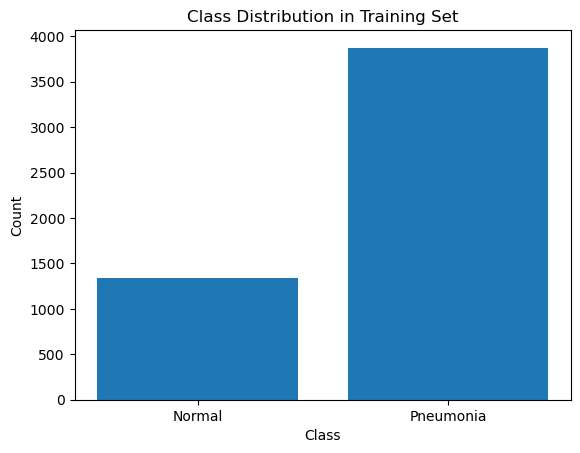

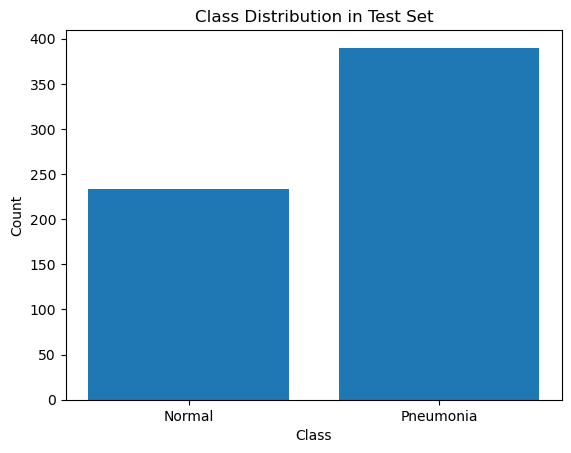

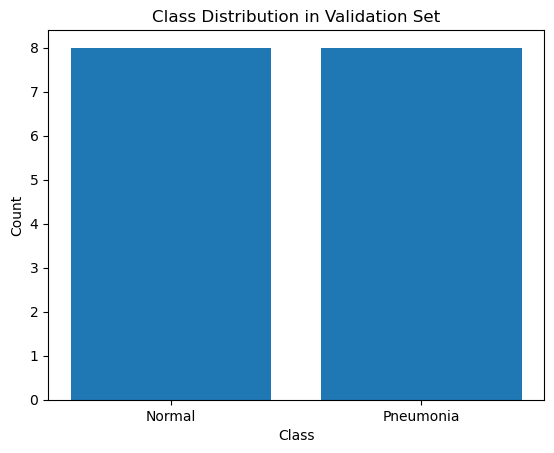

In [22]:
# Get class counts for each set
train_class_counts = np.unique(train_labels, return_counts=True)
test_class_counts = np.unique(test_labels, return_counts=True)
val_class_counts = np.unique(val_labels, return_counts=True)

# Define class labels
class_labels = {0: 'Normal', 1: 'Pneumonia'}

# Plot class distribution
def plot_class_distribution(class_counts, dataset):
    classes, counts = class_counts
    plt.bar(classes, counts)
    plt.title(f'Class Distribution in {dataset} Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(list(class_labels.keys()), [class_labels[c] for c in classes])  # Set x-axis ticks with labels
    plt.show()

# Plot for training set
plot_class_distribution(train_class_counts, 'Training')

# Plot for test set
plot_class_distribution(test_class_counts, 'Test')

# Plot for validation set
plot_class_distribution(val_class_counts, 'Validation')

Looking at the whole dataset, there is a total of 5856 images. As mentioned previously, the training set contains 5216 images, the validation set contains 16 images and the test set contains 624 images. 

- The training set has 3875 images labeled with pneumonia while having 1341 labeled as normal/without pneumonia. This image set seems to have an imbalanced class distribution since there are a long more images with pneumonia. 
- The validation set has small number of images for both classes with 8 images labeled with pneumonia while having 8 labeled as normal/without pneumonia. This could potentially affect the model's ability to generalize effectively.
- The test set has 390 images labeled with pneumonia while having 234 labeled as normal/without pneumonia. This image appears to have a more balanced distribution in comparison to the training set. Even though the the pneumonia images count is still higher than the images without pneumonia, the difference is not as vast as the training set. 

## Baseline Model 

To start, we'll be building a simple neural network model as our baseline model for pneumonia classficiation. Based on the results, I plan to adjust and iterate as needed to find the optimal bets performing model. 

In [12]:
# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                2359308   
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Fitting the model to the training data
results_1 = model_1.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Epoch 1/10
163/163 [==============================] - 25s 140ms/step - loss: 1.5167 - accuracy: 0.7138 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 27s 164ms/step - loss: 0.6329 - accuracy: 0.7429 - val_loss: 0.7121 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 23s 141ms/step - loss: 0.6059 - accuracy: 0.7429 - val_loss: 0.7316 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 21s 127ms/step - loss: 0.5889 - accuracy: 0.7429 - val_loss: 0.7535 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 20s 125ms/step - loss: 0.5791 - accuracy: 0.7429 - val_loss: 0.7744 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 19s 118ms/step - loss: 0.5739 - accuracy: 0.7429 - val_loss: 0.7917 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 20s 124ms/step - loss: 0.5717 - accuracy: 0.7429 - val_loss: 0.8048 - val_ac

In [14]:
# Training Results 
results_train = model_1.evaluate(train_img, train_y)

# Test Results 

results_test = model_1.evaluate(test_img, test_y)

20/20 [==============================] - 3s 108ms/step - loss: 0.6930 - accuracy: 0.6250


In [15]:
print('Train Results:', results_train)
print('Test Results:', results_test)

Train Results: [0.5700258016586304, 0.7429064512252808]
Test Results: [0.6930213570594788, 0.625]


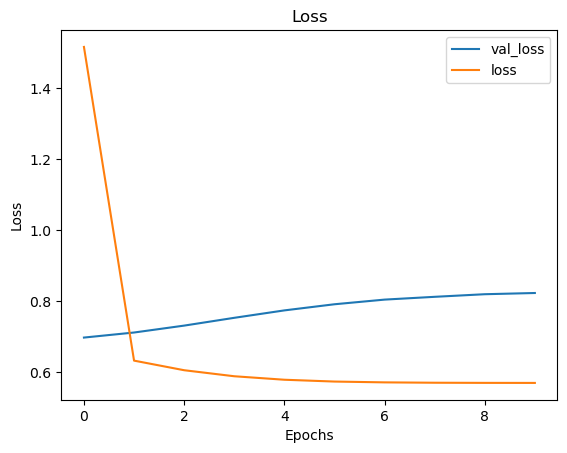

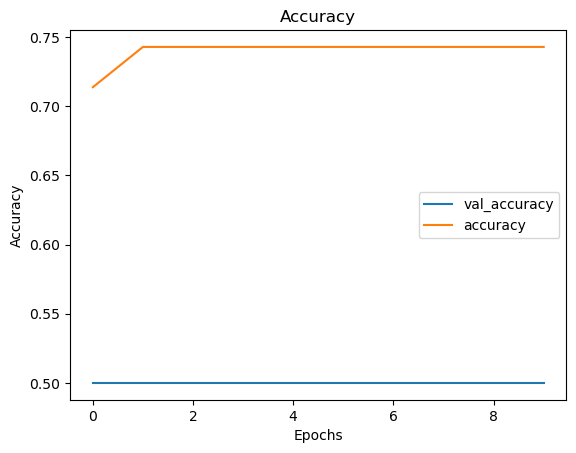

In [16]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_1)

## Model 2

In [17]:
# Model 2 changing activation function in first 2 layers

model_2 = Sequential()
model_2.add(Dense(12, activation='tanh', input_shape=(196608,)))
model_2.add(Dense(8, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_2.summary()

# Fitting the model to the training data
results_2 = model_2.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                2359308   
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,359,421
Trainable params: 2,359,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 22s 123ms/step - loss: 0.5749 - accuracy: 0.7414 - val_loss: 0.8099 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 19s 114ms/step - loss: 0.5707 - accuracy: 0.7429 - val_loss: 0.8365 - val_accuracy: 0.5000
Epoch 3/10
163/163

In [18]:
# Training Results 
results2_train = model_2.evaluate(train_img, train_y)

# Test Results 

results2_test = model_2.evaluate(test_img, test_y)

20/20 [==============================] - 2s 64ms/step - loss: 0.6953 - accuracy: 0.6250


In [19]:
print('Train Results:', results2_train)
print('Test Results:', results2_test)

Train Results: [0.5699954032897949, 0.7429064512252808]
Test Results: [0.6953195333480835, 0.625]


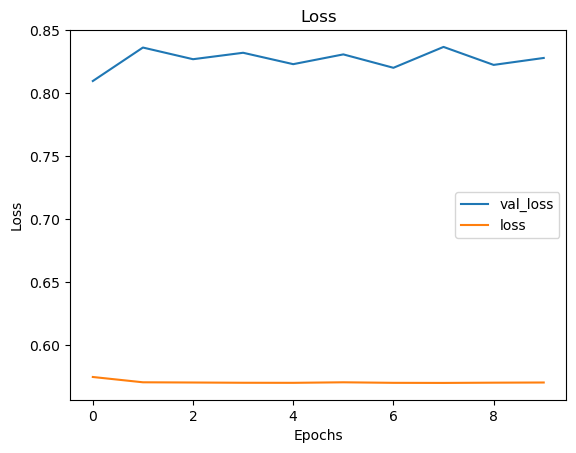

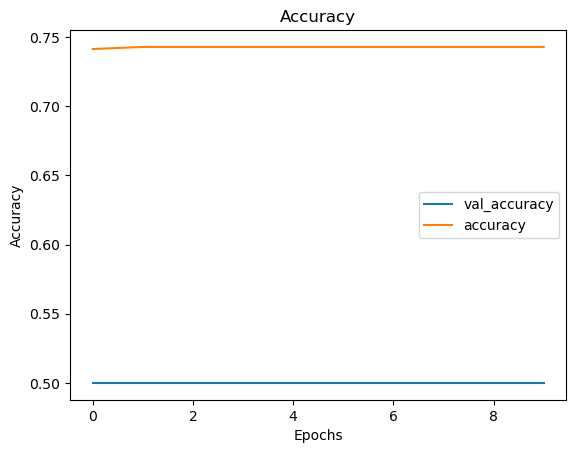

In [20]:
# Creating function to plot loss and accuracy curves

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

# Viewing results 
visualize_training_results(results_2)

## Model 3

In [21]:
# Model 3 
# Adding more neurons per layer and one extra layer 

model_3 = Sequential()
model_3.add(Dense(64, activation='tanh', input_shape=(196608,)))
model_3.add(Dense(32, activation='tanh'))
model_3.add(Dense(16, activation='tanh'))
model_3.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_3.summary()

# Fitting the model to the training data
results_3 = model_3.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                12582976  
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 32s 187ms/step - loss: 0.5761 - accuracy: 0.7391 - val_loss: 0.8030 - val_accuracy: 0.5000
Epoch 2/10
163/163 [=========

In [22]:
# Training Results 
results3_train = model_3.evaluate(train_img, train_y)

# Test Results 

results3_test = model_3.evaluate(test_img, test_y)

20/20 [==============================] - 3s 103ms/step - loss: 0.6952 - accuracy: 0.6250


In [23]:
print('Train Results:', results3_train)
print('Test Results:', results3_test)

Train Results: [0.569995105266571, 0.7429064512252808]
Test Results: [0.695216178894043, 0.625]


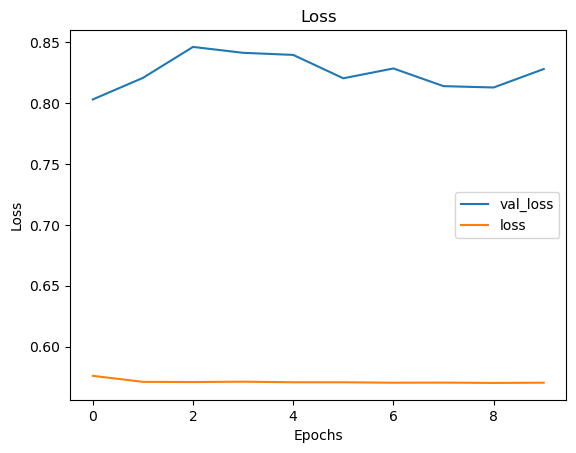

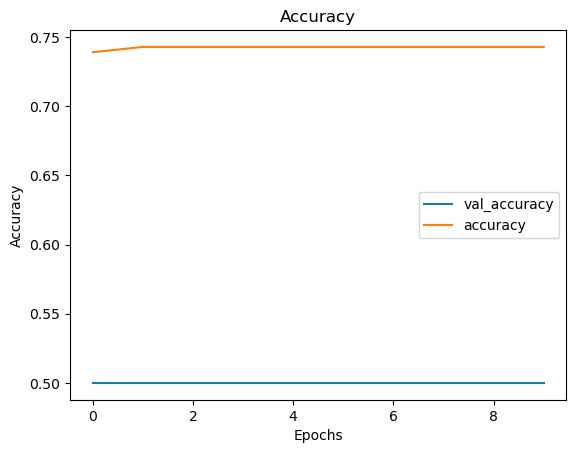

In [24]:
# Viewing results 
visualize_training_results(results_3)

## Model 4

In [25]:
# Model 4
# adjusting activation function from previous model 3

model_4 = Sequential()
model_4.add(Dense(64, activation='relu', input_shape=(196608,)))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_4.summary()

# Fitting the model to the training data
results_4 = model_4.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                12582976  
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
163/163 [==============================] - 44s 257ms/step - loss: 0.8471 - accuracy: 0.8286 - val_loss: 0.2849 - val_accuracy: 0.8750
Epoch 2/10
163/163 [=========

In [26]:
# Training Results 
results4_train = model_4.evaluate(train_img, train_y)

# Test Results 
results4_test = model_4.evaluate(test_img, test_y)

print('Train Results:', results4_train)
print('Test Results:', results4_test)


20/20 [==============================] - 2s 75ms/step - loss: 0.9515 - accuracy: 0.7660
Train Results: [0.08690128475427628, 0.9695168733596802]
Test Results: [0.9514895677566528, 0.7660256624221802]


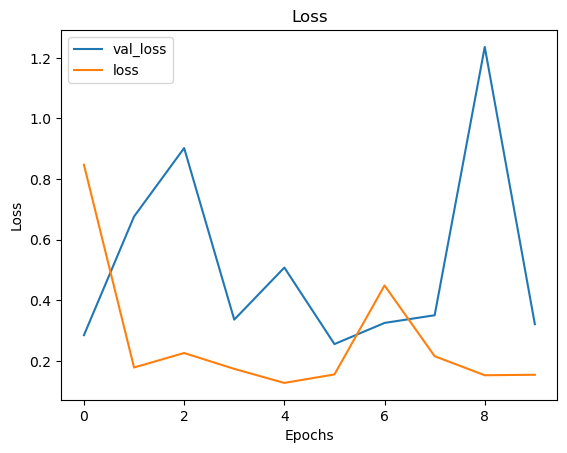

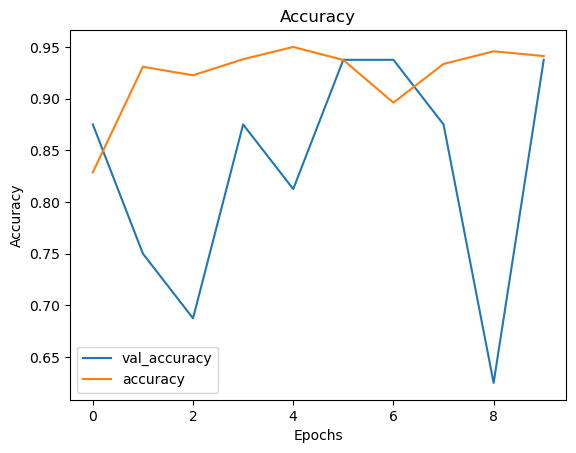

In [27]:
# Viewing results 
visualize_training_results(results_4)

## Model 5

In [28]:
# Model 5 increased epochs from 10 to 20 


model_5 = Sequential()
model_5.add(Dense(64, activation='relu', input_shape=(196608,)))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(16, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_5.summary()

# Fitting the model to the training data
results_5 = model_5.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                12582976  
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 32s 187ms/step - loss: 1.0587 - accuracy: 0.8273 - val_loss: 0.9226 - val_accuracy: 0.6875
Epoch 2/20
163/163 [=========

In [29]:
# Training Results 
results5_train = model_5.evaluate(train_img, train_y)

# Test Results 
results5_test = model_5.evaluate(test_img, test_y)

print('Train Results:', results5_train)
print('Test Results:', results5_test)


20/20 [==============================] - 2s 73ms/step - loss: 0.5025 - accuracy: 0.8141
Train Results: [0.1903623342514038, 0.9321318864822388]
Test Results: [0.5024653673171997, 0.8141025900840759]


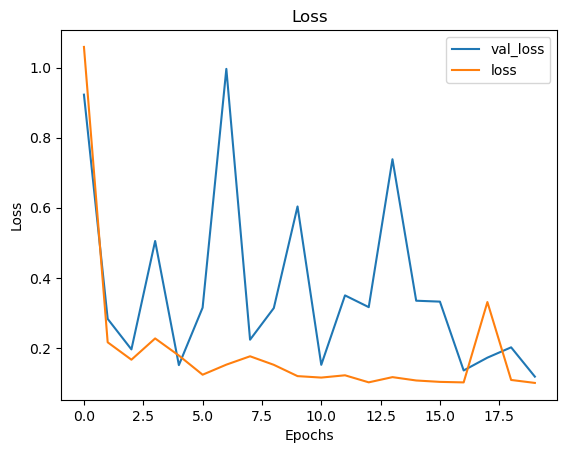

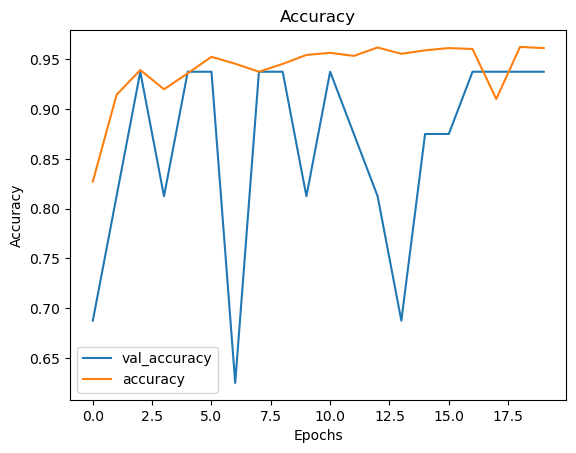

In [30]:
# Viewing results 
visualize_training_results(results_5)

With the increase to 20 epochs the training accuracy increased while test accuracy also increased greatly from the previous model. Looking at the top visual, we can see that loss seems to be improving as Epochs are increase. 

I plan to increase the Epochs to 50 to see how this influences the metrics. 

## Model 6

In [31]:
# Model 6 increased epochs from 20 to 30


model_6 = Sequential()
model_6.add(Dense(64, activation='relu', input_shape=(196608,)))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(16, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_6.summary()

# Fitting the model to the training data
results_6 = model_6.fit(train_img, train_y, 
                        epochs=30, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                12582976  
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
163/163 [==============================] - 44s 254ms/step - loss: 1.7641 - accuracy: 0.8232 - val_loss: 2.6814 - val_accuracy: 0.6250
Epoch 2/30
163/163 [=========

In [32]:
# Training Results 
results6_train = model_6.evaluate(train_img, train_y)

# Test Results 
results6_test = model_6.evaluate(test_img, test_y)

print('Train Results:', results6_train)
print('Test Results:', results6_test)


20/20 [==============================] - 3s 108ms/step - loss: 0.5682 - accuracy: 0.8125
Train Results: [0.09268513321876526, 0.9647239446640015]
Test Results: [0.5682278275489807, 0.8125]


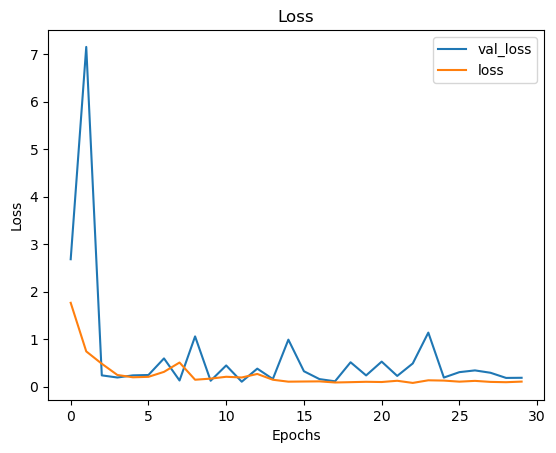

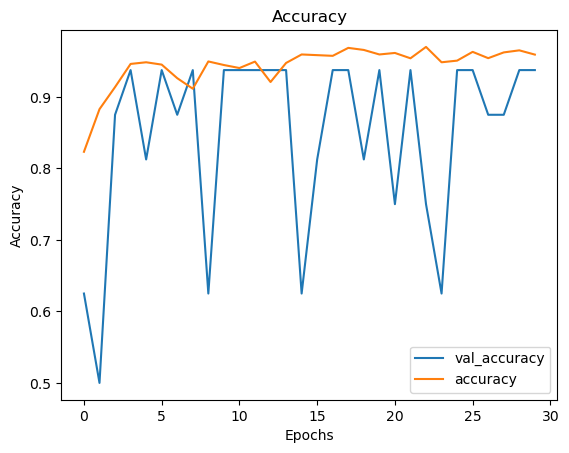

In [33]:
# Viewing results 
visualize_training_results(results_6)

With increasing Epochs from 20 to 30, there was slight improvement training accuracy going from ~93% to ~96%, however test accuracy remained virtually the same at ~81%. Since the model seemed to increase in overfitting with 30 Epochs. Planning to try one additional adjustment regarding Epochs with testing model by reducing to 15 Epochs. 

## Model 7

In [34]:
# Model 7 Epochs will be adjusted to 15


model_7 = Sequential()
model_7.add(Dense(64, activation='relu', input_shape=(196608,)))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(16, activation='relu'))
model_7.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_7.summary()

# Fitting the model to the training data
results_7 = model_7.fit(train_img, train_y, 
                        epochs=15, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                12582976  
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
163/163 [==============================] - 45s 265ms/step - loss: 2.3676 - accuracy: 0.8459 - val_loss: 1.0944 - val_accuracy: 0.6875
Epoch 2/15
163/163 [=========

In [35]:
# Training Results 
results7_train = model_7.evaluate(train_img, train_y)

# Test Results 
results7_test = model_7.evaluate(test_img, test_y)

print('Train Results:', results7_train)
print('Test Results:', results7_test)

20/20 [==============================] - 3s 109ms/step - loss: 0.5536 - accuracy: 0.8045
Train Results: [0.22628697752952576, 0.9112346768379211]
Test Results: [0.5536491870880127, 0.8044871687889099]


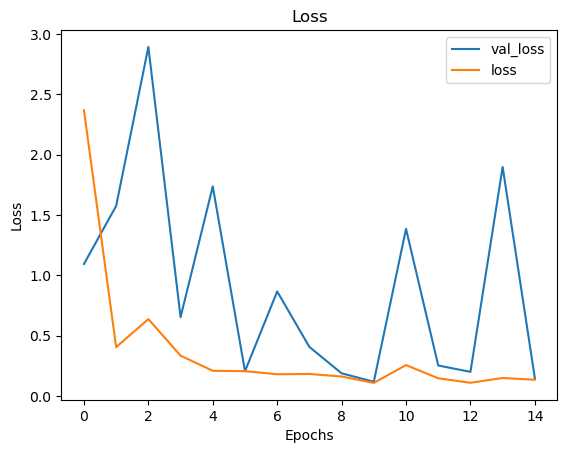

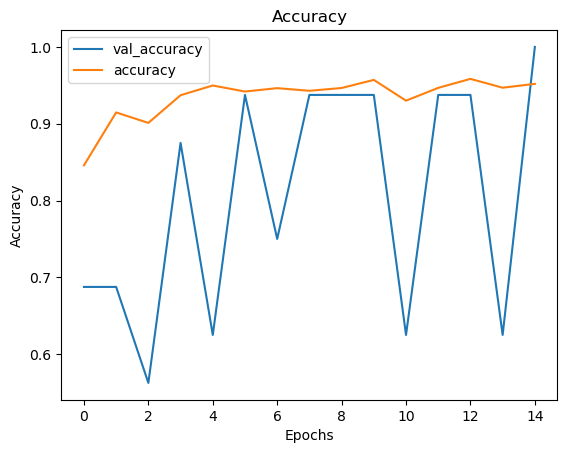

In [37]:
# Viewing results 
visualize_training_results(results_7)

## Model 8

In [54]:
# Model 8 Epochs of 20 
# L1 regularization added

model_8 = Sequential()
model_8.add(Dense(64, activation='relu', input_shape=(196608,)))
model_8.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
model_8.add(Dense(16, activation='relu'))
model_8.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_8.summary()

# Fitting the model to the training data
results_8 = model_8.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                12582976  
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,585,601
Trainable params: 12,585,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 74s 435ms/step - loss: 2.6271 - accuracy: 0.8455 - val_loss: 1.2184 - val_accuracy: 0.8750
Epoch 2/20
163/163 [========

In [55]:
# Training Results 
results8_train = model_8.evaluate(train_img, train_y)

# Test Results 
results8_test = model_8.evaluate(test_img, test_y)

print('Train Results:', results8_train)
print('Test Results:', results8_test)

20/20 [==============================] - 4s 176ms/step - loss: 1.3803 - accuracy: 0.7212
Train Results: [0.25414934754371643, 0.9675996899604797]
Test Results: [1.3803304433822632, 0.7211538553237915]


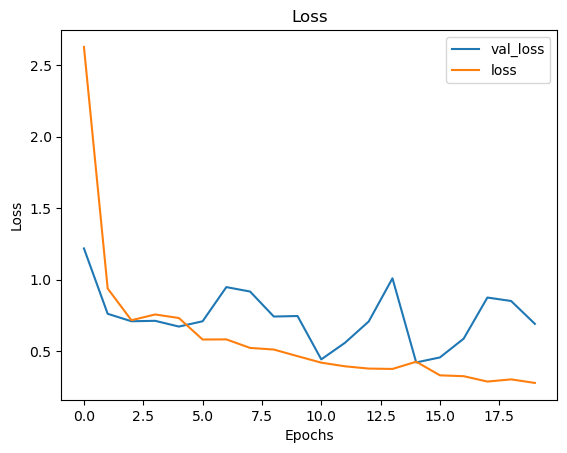

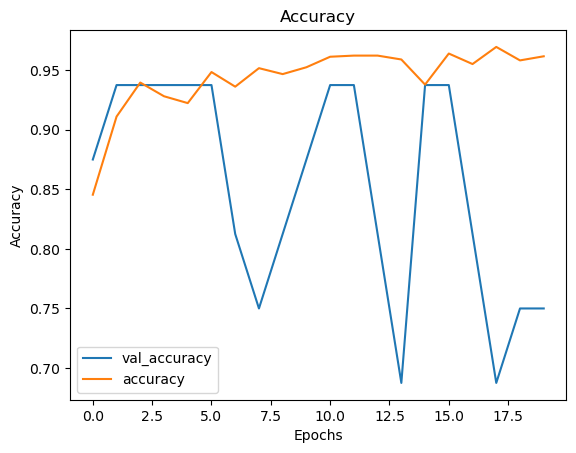

In [56]:
# Viewing results 
visualize_training_results(results_8)

## Model 9

In [57]:
# Model 9 Epochs of 20, added one extra layer
# added l2 regularization to multiple layers


model_9 = Sequential()
model_9.add(Dense(64, activation='relu', input_shape=(196608,)))
model_8.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
model_9.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_9.add(Dense(8, activation='relu', kernel_regularizer=l2(0.05)))
model_9.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_9.summary()

# Fitting the model to the training data
results_9 = model_9.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                12582976  
                                                                 
 dense_54 (Dense)            (None, 16)                1040      
                                                                 
 dense_55 (Dense)            (None, 8)                 136       
                                                                 
 dense_56 (Dense)            (None, 1)                 9         
                                                                 
Total params: 12,584,161
Trainable params: 12,584,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 76s 437ms/step - loss: 1.9623 - accuracy: 0.6848 - val_loss: 1.5152 - val_accuracy: 0.5000
Epoch 2/20
163/163 [========

KeyboardInterrupt: 

In [59]:
# Model 9 Epochs of 20, added one extra layer
# took away regularization
# adjusted neurons in layers and added 1 additional layer


model_9 = Sequential()
model_9.add(Dense(128, activation='relu', input_shape=(196608,)))
model_8.add(Dense(64, activation='relu'))
model_9.add(Dense(32, activation='relu'))
model_9.add(Dense(16, activation='relu'))
model_9.add(Dense(8, activation='relu'))
model_9.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_9.summary()

# Fitting the model to the training data
results_9 = model_9.fit(train_img, train_y, 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 128)               25165952  
                                                                 
 dense_64 (Dense)            (None, 32)                4128      
                                                                 
 dense_65 (Dense)            (None, 16)                528       
                                                                 
 dense_66 (Dense)            (None, 8)                 136       
                                                                 
 dense_67 (Dense)            (None, 1)                 9         
                                                                 
Total params: 25,170,753
Trainable params: 25,170,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [=====================

In [60]:
# Training Results 
results9_train = model_9.evaluate(train_img, train_y)

# Test Results 
results9_test = model_9.evaluate(test_img, test_y)

print('Train Results:', results9_train)
print('Test Results:', results9_test)

20/20 [==============================] - 5s 121ms/step - loss: 1.4485 - accuracy: 0.7019
Train Results: [0.10469038784503937, 0.9534125924110413]
Test Results: [1.4485394954681396, 0.7019230723381042]


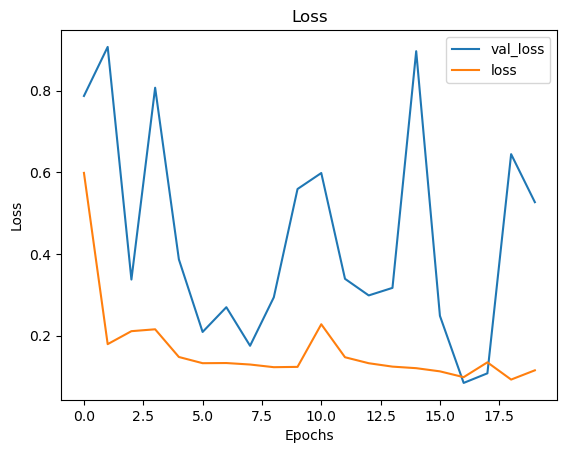

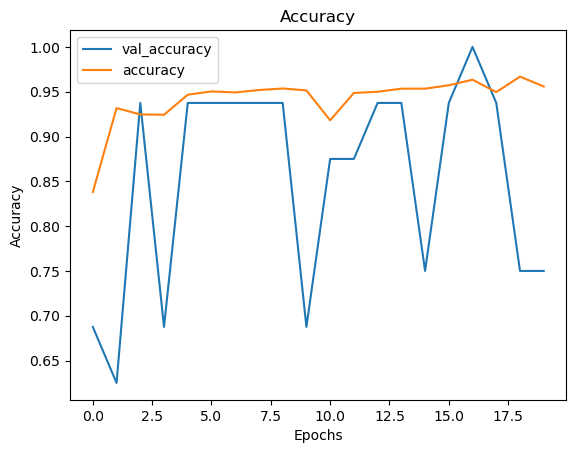

In [61]:
# Viewing results 
visualize_training_results(results_9)

## Building the CNN Model

In [72]:
# Baseline CNN

cnn_model = Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(2, activation='softmax'))


# Reviewing model summary
cnn_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 flatten_2 (Flatten)         (None, 230400)          

In [73]:
# Compiling model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fitting the model

cnn_model.fit(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 442s 3s/step - loss: 0.3070 - accuracy: 0.8815
Epoch 2/10
163/163 [==============================] - 561s 3s/step - loss: 0.1055 - accuracy: 0.9647
Epoch 3/10
163/163 [==============================] - 636s 4s/step - loss: 0.0682 - accuracy: 0.9764
Epoch 4/10
163/163 [==============================] - 652s 4s/step - loss: 0.0505 - accuracy: 0.9803
Epoch 5/10
163/163 [==============================] - 495s 3s/step - loss: 0.0337 - accuracy: 0.9877
Epoch 6/10
163/163 [==============================] - 477s 3s/step - loss: 0.0234 - accuracy: 0.9918
Epoch 7/10
163/163 [==============================] - 503s 3s/step - loss: 0.0132 - accuracy: 0.9954
Epoch 8/10
163/163 [==============================] - 471s 3s/step - loss: 0.0106 - accuracy: 0.9962
Epoch 9/10
163/163 [==============================] - 502s 3s/step - loss: 0.0090 - accuracy: 0.9971
Epoch 10/10
163/163 [==============================] - 486s 3s/step - loss: 0.0276 - accura

In [74]:
# Evaluating the model
cnn_result_train = cnn_model.evaluate(train_images, train_labels)
cnn_result_test = cnn_model.evaluate(test_images, test_labels)


print('Train Results:', cnn_result_train)
print('Test Results:', cnn_result_test)

20/20 [==============================] - 26s 1s/step - loss: 1.7180 - accuracy: 0.7644
Train Results: [0.05409827083349228, 0.9831288456916809]
Test Results: [1.7180132865905762, 0.7644230723381042]


## CNN Model 2

In [75]:
# CNN Model 2
# Changed loss function to binary crossentropy
# Adjusted final layer to have 1 neuron while switching the activation function to sigmoid

cnn_model2 = Sequential()
cnn_model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
cnn_model2.add(layers.MaxPooling2D((2, 2)))
cnn_model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model2.add(layers.MaxPooling2D((2, 2)))
cnn_model2.add(layers.Conv2D(64, (3, 3), activation='relu'))

cnn_model2.add(layers.Flatten())
cnn_model2.add(layers.Dense(64, activation='relu'))
cnn_model2.add(layers.Dense(1, activation='softmax'))


# Reviewing model summary
cnn_model2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 230400)          

In [77]:
# Compiling model
cnn_model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fitting the model

cnn_model2.fit(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 392s 2s/step - loss: 0.3540 - accuracy: 0.7429
Epoch 2/10
163/163 [==============================] - 343s 2s/step - loss: 0.1086 - accuracy: 0.7429
Epoch 3/10
163/163 [==============================] - 344s 2s/step - loss: 0.0875 - accuracy: 0.7429
Epoch 4/10
163/163 [==============================] - 343s 2s/step - loss: 0.0576 - accuracy: 0.7429
Epoch 5/10
163/163 [==============================] - 356s 2s/step - loss: 0.0414 - accuracy: 0.7429
Epoch 6/10
163/163 [==============================] - 335s 2s/step - loss: 0.0403 - accuracy: 0.7429
Epoch 7/10
163/163 [==============================] - 370s 2s/step - loss: 0.0209 - accuracy: 0.7429
Epoch 8/10
163/163 [==============================] - 359s 2s/step - loss: 0.0177 - accuracy: 0.7429
Epoch 9/10
163/163 [==============================] - 334s 2s/step - loss: 0.0125 - accuracy: 0.7429
Epoch 10/10
163/163 [==============================] - 335s 2s/step - loss: 0.0103 - accura

In [78]:
# Evaluating the model
cnn_result_train2 = cnn_model2.evaluate(train_images, train_labels)
cnn_result_test2 = cnn_model2.evaluate(test_images, test_labels)


print('Train Results:', cnn_result_train2)
print('Test Results:', cnn_result_test2)

20/20 [==============================] - 15s 674ms/step - loss: 1.5583 - accuracy: 0.6250
Train Results: [0.02156638912856579, 0.7429064512252808]
Test Results: [1.5583068132400513, 0.625]


# Baseline model

model_1 = Sequential()
model_1.add(Dense(12, activation='relu', input_shape=(196608,)))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

# Compiling model with following parameters
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Inspecting model summary

model_1.summary()

# Fitting the model to the training data
results_2 = model_2.fit(train_img, train_y, 
                        epochs=10, 
                        batch_size=32, 
                        validation_data=(val_img, val_y))

# Training Results 
results3_train = model_3.evaluate(train_img, train_y)

# Test Results 

results3_test = model_3.evaluate(test_img, test_y)

print('Train Results:', results3_train)
print('Test Results:', results3_test)

# Viewing results 
visualize_training_results(results_3)